In [10]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# [4월 20일]
---

## # 1D 컨브넷
---

- 케라스에서 1D 컨브넷은 `Conv1D` 층을 사용하여 구현한다.
- `Conv1D`는 `Conv2D`와 인터페이스가 비슷하다. `(samples, time, features)` 크기의 3D 텐서를 입력받고 비슷한 형태의 3D 텐서를 반환한다.. 
- 합성곱 윈도우는 시간 축의 1D 윈도우이다. 즉, 입력 텐서의 두 번째 축이다.

- 검증 정확도는 LSTM 보다 낮지만 CPU, GPU에서 더 빠르게 실행된다.
- 단어 수준의 감성분류 작업에 순환 네트워크를 대신하여 빠르고 경제적인 1D 컨브넷을 사용할 수 있다.


### # IMDB 데이터 전처리
---
- 간단한 두 개 층으로 된 1D 컨브넷을 만들어 익숙한 IMDB 감성 분류 문제에 적용

In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000
max_len = 500

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = max_features)

print(len(X_train), '훈련 시퀀스')
print(len(X_test), '테스트 시퀀스')

X_train = sequence.pad_sequences(X_train, maxlen = max_len)
X_test = sequence.pad_sequences(X_test, maxlen = max_len)

print(X_train.shape)
print(X_test.shape)

17473536/17464789 [==============================] - 0s 0us/step
25000 훈련 시퀀스
25000 테스트 시퀀스
(25000, 500)
(25000, 500)


### # 1D 컨브넷 모델 구성
---
- GlobalAveragePooling1D, GlobalMaxPooling1D 풀링은 (samples, timesteps, features) 크기의 텐서를 입력받고 (samples, features) 크기의 텐서를 출력한다. 즉, 시간 축 전체에 풀링을 적용한다.

In [9]:
# 모델 훈련

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length = max_len))
model.add(layers.Conv1D(32, 7, activation = 'relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation = 'relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 494, 32)           28704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 98, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                

In [10]:
model.compile(optimizer = RMSprop(learning_rate = 1e-4),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(X_train, y_train,
                    epochs = 10,
                    batch_size = 128,
                    validation_split = 0.2)

Epoch 1/10
157/157 [==============================] - 13s 11ms/step - loss: 0.7038 - acc: 0.5195 - val_loss: 0.6879 - val_acc: 0.5400
Epoch 2/10
157/157 [==============================] - 1s 9ms/step - loss: 0.6672 - acc: 0.6608 - val_loss: 0.6728 - val_acc: 0.6002
Epoch 3/10
157/157 [==============================] - 1s 9ms/step - loss: 0.6309 - acc: 0.7441 - val_loss: 0.6323 - val_acc: 0.7020
Epoch 4/10
157/157 [==============================] - 1s 9ms/step - loss: 0.5566 - acc: 0.7990 - val_loss: 0.5330 - val_acc: 0.7792
Epoch 5/10
157/157 [==============================] - 1s 9ms/step - loss: 0.4376 - acc: 0.8353 - val_loss: 0.4609 - val_acc: 0.8158
Epoch 6/10
157/157 [==============================] - 1s 9ms/step - loss: 0.3579 - acc: 0.8653 - val_loss: 0.4243 - val_acc: 0.8432
Epoch 7/10
157/157 [==============================] - 1s 9ms/step - loss: 0.3070 - acc: 0.8874 - val_loss: 0.4037 - val_acc: 0.8560
Epoch 8/10
157/157 [==============================] - 1s 9ms/step - loss: 

782/782 [==============================] - 2s 3ms/step - loss: 0.4610 - acc: 0.8600


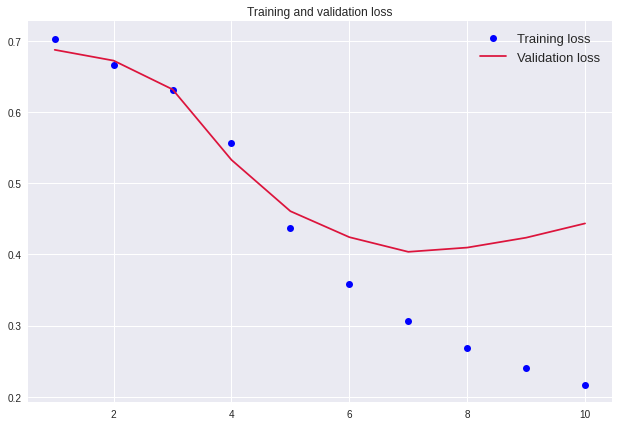

In [14]:
# 검증 시각화

model.evaluate(X_test, y_test)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize = (23, 7))

fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, color = 'crimson', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(fontsize = 13)

plt.show()

## # RNN과 CNN을 연결
---

### # 날씨 데이터 로드 및 전처리
---

In [13]:

import os

data_dir = '/content/drive/MyDrive/workspace/cakd5/m9_딥러닝 알고리즘 구현/data/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

# 표준화
mean = float_data[:200000].mean(axis = 0)
std = float_data[:200000].std(axis = 0)
float_data -= mean
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)

val_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 200001,
                      max_index = 300000,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)

test_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 300001,
                      max_index = None,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
# generator() 함수는 while문을 사용하여 무한 반복되기 때문에 검증 세트와 테스트 세트를 한 번 순회하는 횟수를 알려주어야 한다.
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### # 1D 컨브넷 단일 모델 구성
---

In [15]:
# 모델 훈련과 평가

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation = 'relu',
                        input_shape = (None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation = 'relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation = 'relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(),
              loss = 'mae')

history = model.fit(train_gen,
                    steps_per_epoch = 500,
                    epochs = 20,
                    validation_data = val_gen,
                    validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 16s 32ms/step - loss: 0.4255 - val_loss: 0.4320
Epoch 2/20
500/500 [==============================] - 15s 31ms/step - loss: 0.3657 - val_loss: 0.4259
Epoch 3/20
500/500 [==============================] - 11s 23ms/step - loss: 0.3400 - val_loss: 0.4973
Epoch 4/20
500/500 [==============================] - 16s 31ms/step - loss: 0.3224 - val_loss: 0.4299
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3113 - val_loss: 0.4735
Epoch 6/20
500/500 [==============================] - 15s 31ms/step - loss: 0.3020 - val_loss: 0.4762
Epoch 7/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2957 - val_loss: 0.4612
Epoch 8/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2898 - val_loss: 0.4496
Epoch 9/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2838 - val_loss: 0.4446
Epoch 10/20
500/500 [==============================] - 14s 29ms/step - loss: 0.278

930/930 [==============================] - 8s 9ms/step - loss: 10.0933


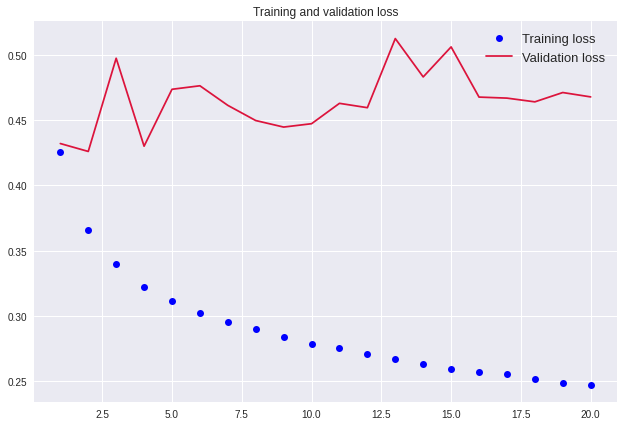

In [17]:
# 검증 시각화

model.evaluate(test_gen, steps = test_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize = (23, 7))

fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, color = 'crimson', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend(fontsize = 13)

plt.show()

### # 1D 컨브넷 + GRU 모델 구성
---
- 1D 컨브넷을 RNN 이전의 전처리 단계로 사용
- RNN으로 처리하기에는 현실적으로 너무 긴 시퀀스를 다룰 때 도움이 된다.

In [18]:
# 고밀도 데이터 제너레이터로 데이터를 새롭게 구성
# step을 절반으로 줄였으므로 시계열 데이터는 2배로 길어지며 따라서 시계열 데이터를 더 촘촘히 볼 수 있다.

step = 3 # 30분마다 1포인트
lookback = 1440
delay = 144

train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step)

val_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 200001,
                      max_index = 300000,
                      shuffle = True,
                      step = step)

test_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 300001,
                      max_index = None,
                      shuffle = True,
                      step = step)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
# generator() 함수는 while문을 사용하여 무한 반복되기 때문에 검증 세트와 테스트 세트를 한 번 순회하는 횟수를 알려주어야 한다.
val_steps = (300000 - 200001 - lookback) // 128

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // 128

In [21]:
# 모델 훈련 및 검증

model = Sequential()
model.add(layers.Conv1D(32, 5, activation = 'relu',
                        input_shape = (None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation = 'relu'))
model.add(layers.GRU(32, dropout = 0.1, recurrent_dropout = 0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer = RMSprop(),
              loss = 'mae')
history = model.fit(train_gen,
                    steps_per_epoch = 500,
                    epochs = 20,
                    validation_data = val_gen,
                    validation_steps = val_steps)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, None, 32)          2272      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_12 (Conv1D)          (None, None, 32)          5152      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
__________________________________________________

930/930 [==============================] - 46s 49ms/step - loss: 0.3273


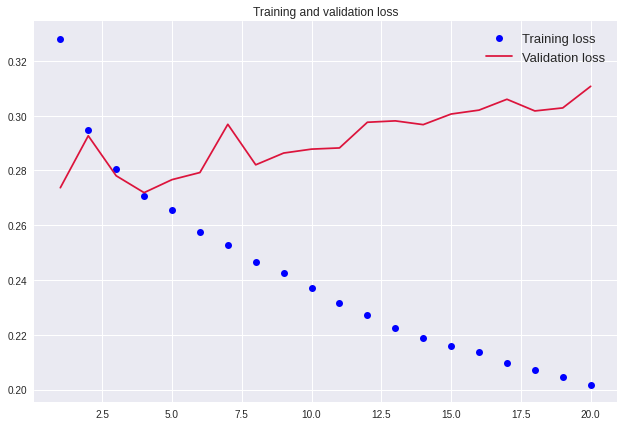

In [22]:
# 검증 시각화
# 규제가 있는 GRU모델만큼 좋지는 않지만 처리 속도가 훨씬 빠르다.

model.evaluate(test_gen, steps = test_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize = (23, 7))

fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, color = 'crimson', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend(fontsize = 13)

plt.show()